# Effect of repealing Child Tax Credit with Child Dividend

This identifies beneficiaries of the Child Tax Credit by modeling its repeal. Both repeal from current (2017) state and TCJA state are considered on a static basis. Change to after-tax income by decile and share of after-tax income held by top 10% are calculated.

*Data: CPS  |  Tax year: 2018  |  Type: Static  |  Author: Max Ghenis  |  Date run: 2018-02-20*

## Setup

### Imports

In [1]:
import taxcalc as tc
import pandas as pd
import numpy as np
import copy
from bokeh.io import show, output_notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import urllib as url_lib  # On Python 3.6 use "import urllib.request as url_lib".

In [2]:
tc.__version__

'0.16.1'

In [3]:
sns.set_style('white')
DPI = 300
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi']= DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
roboto = {'fontname':'Roboto-Light'}
opensans = {'fontname':'Open Sans'}
mpl.rcParams['font.sans-serif'] = 'Roboto-Regular'
mpl.rcParams['font.family'] = 'sans-serif'

In [5]:
pd.set_option('precision', 1)

### Create policies

Load reforms from GitHub. Policies and reforms are named according to this convention:

**`{reform}_{year}_{object}`**

For example:

* `noctc_2017_policy`: Policy without CTC using 2017 law.
* `ubi_2018_calc`: Calculator replacing CTC with UBI using 2018 (current) law.

In [6]:
# Folders where reforms live.
GITHUB_BASE_URL = 'https://raw.githubusercontent.com/'

TAXCALC_GITHUB_BASE_URL = (GITHUB_BASE_URL +
                           'open-source-economics/Tax-Calculator/master/' +
                           'taxcalc/reforms/')

def read_url(url):
    return url_lib.urlopen(url).read()

def read_reform_taxcalc_github(reform_name):
    return read_url(TAXCALC_GITHUB_BASE_URL + reform_name + '.json')

def policy_from_reform(reform):
    pol = tc.Policy()
    pol.implement_reform(reform['policy'])
    if pol.reform_errors:
        print(pol.reform_errors)
    return pol

def create_static_policy_taxcalc_github(reform_name):
    reform = tc.Calculator.read_json_param_objects(
        read_reform_taxcalc_github(reform_name), None)
    return policy_from_reform(reform)

In [7]:
y2017_policy = create_static_policy_taxcalc_github(
    '2017_law')

noctc_reform = {
    2018: {
        '_CTC_c': [0],
        '_DependentCredit_Child_c': [0]
    }}

### Specify `Calculator` objects for static analyses

In [8]:
recs = tc.Records.cps_constructor()

In [9]:
def static_baseline_calc(year):
    calc = tc.Calculator(records=recs, policy=tc.Policy())
    calc.advance_to_year(year)
    calc.calc_all()
    return calc

In [10]:
def weighted_sum(df, col):
    return (df[col] * df['s006']).sum()

In [11]:
def child_ubi_reform(amount):
    return {2018: {'_UBI_u18': [amount],
                   '_UBI_ecrt': [1.0]}}

In [12]:
def add_weighted_quantiles(df, col):
    df.sort_values(by=col, inplace=True)
    col_pctile = col + '_percentile_exact'
    df[col_pctile] = 100 * df['s006'].cumsum() / df['s006'].sum()
    # "Null out" negatives using -1, since integer arrays can't be NaN.
    # TODO: Should these be null floats?
    df[col_pctile] = np.where(df[col] >= 0, df[col_pctile], 0)
    # Reduce top record, otherwise it's incorrectly rounded up.
    df[col_pctile] = np.where(df[col_pctile] >= 99.99999, 99.99999, df[col_pctile])
    df[col + '_percentile'] = np.ceil(df[col_pctile]).astype(int)
    df[col + '_decile'] = np.ceil(df[col_pctile] / 10).astype(int)
    df[col + '_quintile'] = np.ceil(df[col_pctile] / 20).astype(int)
    return df

In [13]:
def static_calc(use_2017_law=False, 
                ctc_treatment='keep',
                child_ubi_amount=0,
                year=2018,
                cols=['s006', 'aftertax_income', 'expanded_income', 'nu18', 'n24', 'XTOT']):
    """Creates static Calculator.

    Args:
        use_2017_law: Whether to use 2017 law vs. current law. Defaults to False.
        ctc_treatment: How the Child Tax Credit is treated. Options include:
            * 'keep': No change. Default.
            * 'repeal': End entirely.
            * 'rev_neutral_ubi': Replace with revenue-neutral child UBI.
            * 'no_cut_ubi': [NOT YET IMPLEMENTED] 
                Replace with a child UBI equal to the current maximum value.
        year: Year to advance calculations to.
        cols: Columns to extract per Calculator record. 
            Defaults to ['s006', 'expanded_income', 'aftertax_income', 'nu18', 'n24', 'XTOT'].
        
    Returns:
        DataFrame with `cols` and percentile, decile, and quintile of after-tax income.
    """
    # Initiate policy using either 2017 or current law.
    if use_2017_law:
        pol = copy.deepcopy(y2017_policy)
    else:
        pol = tc.Policy()
    # Enact reform based on ctc_treatment.
    # Repeal CTC unless it's kept.
    if ctc_treatment != 'keep':
        pol.implement_reform(noctc_reform)
    if child_ubi_amount > 0:
        pol.implement_reform(child_ubi_reform(child_ubi_amount))
    # Calculate. This is needed to calculate the revenue-neutral UBI.
    calc = tc.Calculator(records=recs, policy=pol)
    calc.advance_to_year(year)
    calc.calc_all()
    # TODO: Calculate revenue for revenue-neutral UBI.
    # Create DataFrame and add identifiers.
    df = calc.dataframe(cols)
    # Add percentiles.
    df = add_weighted_quantiles(df, 'expanded_income')
    df = add_weighted_quantiles(df, 'aftertax_income')
    # Add identifiers.
    df['use_2017_law'] = use_2017_law
    df['ctc_treatment'] = ctc_treatment
    # What's the column for the ID?
    df['id'] = df.index
    # Add weighted sums.
    df['expanded_income_b'] = df['expanded_income'] * df['s006'] / 1e9
    df['aftertax_income_b'] = df['aftertax_income'] * df['s006'] / 1e9
    df['n24_m'] = df['n24'] * df['s006'] / 1e6
    df['nu18_m'] = df['nu18'] * df['s006'] / 1e6
    df['XTOT_m'] = df['XTOT'] * df['s006'] / 1e6
    return df

In [14]:
scenarios_pre_ubi = pd.concat([
    static_calc(use_2017_law=False, ctc_treatment='keep'),
    static_calc(use_2017_law=False, ctc_treatment='repeal'),
    static_calc(use_2017_law=True, ctc_treatment='keep'),
    static_calc(use_2017_law=True, ctc_treatment='repeal')])

You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.
You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.
You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.
You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.


In [15]:
scenarios_pre_ubi.sample(5)

,s006,aftertax_income,expanded_income,nu18,n24,XTOT,expanded_income_percentile_exact,expanded_income_percentile,expanded_income_decile,expanded_income_quintile,...,aftertax_income_decile,aftertax_income_quintile,use_2017_law,ctc_treatment,id,expanded_income_b,aftertax_income_b,n24_m,nu18_m,XTOT_m
57259,1193.3,21988.0,27712.6,0.0,0.0,1.0,26.4,27,3,2,...,3,2,True,keep,57259,3.3e-02,2.6e-02,0.0e+00,0.0e+00,1.2e-03
426600,200.8,62519.6,71648.9,1.0,1.0,4.0,64.0,64,7,4,...,7,4,True,keep,426600,1.4e-02,1.3e-02,2.0e-04,2.0e-04,8.0e-04
314707,47.0,217888.1,220492.7,0.0,0.0,3.0,95.0,96,10,5,...,10,5,False,keep,314707,1.0e-02,1.0e-02,0.0e+00,0.0e+00,1.4e-04
176101,7.3,71186.6,71186.6,0.0,0.0,1.0,63.8,64,7,4,...,8,4,False,keep,176101,5.2e-04,5.2e-04,0.0e+00,0.0e+00,7.3e-06
8599,52.3,138360.7,180801.5,1.0,0.0,2.0,92.1,93,10,5,...,10,5,True,keep,8599,9.4e-03,7.2e-03,0.0e+00,5.2e-05,1.0e-04


## Program cost and child allowance calculation



In [16]:
aftertax_income_summary = (
    scenarios_pre_ubi.groupby(['use_2017_law', 'ctc_treatment'], as_index=False).
    apply(lambda x: 
          pd.Series({
              'aftertax_income': weighted_sum(x, 'aftertax_income'), 
              'nu18': weighted_sum(x, 'nu18')}))).reset_index()
nu18_total = aftertax_income_summary['nu18'][0]

In [17]:
aftertax_income_chg = aftertax_income_summary.pivot(
    index='use_2017_law',
    columns='ctc_treatment',
    values='aftertax_income'
)
aftertax_income_chg['chg'] = aftertax_income_chg['keep'] - aftertax_income_chg['repeal']
aftertax_income_chg['chg_b'] = aftertax_income_chg['chg'] / 1e9
aftertax_income_chg['child_ubi'] = aftertax_income_chg['chg'] / nu18_total
aftertax_income_chg[['chg_b', 'child_ubi']]

ctc_treatment,chg_b,child_ubi
use_2017_law,,
False,120.1,1464.5
True,51.8,632.1


$52B aligns with [TPC's 2017 estimate](http://www.taxpolicycenter.org/publications/refundable-credits-earned-income-tax-credit-and-child-tax-credit/full).

\$120B aligns with this \$52B plus [JCT's estimate](https://www.jct.gov/publications.html?func=startdown&id=5053) that TCJA's non-SSN reforms would cost \$68B starting in 2019. The 2018 estimate of $29B does not capture the refundable portions.

### Add UBI scenarios

TODO: Confirm maximum CTCs by comparing keep and repeal per tax unit.

In [18]:
scenarios = pd.concat([
    scenarios_pre_ubi,
    static_calc(use_2017_law=False, ctc_treatment='rev_neutral_ubi',
                child_ubi_amount=aftertax_income_chg.loc[False, 'child_ubi']),
    static_calc(use_2017_law=True, ctc_treatment='rev_neutral_ubi',
                child_ubi_amount=aftertax_income_chg.loc[True, 'child_ubi']),
    static_calc(use_2017_law=False, ctc_treatment='top_ubi',
                child_ubi_amount=2000),
    static_calc(use_2017_law=True, ctc_treatment='top_ubi',
                child_ubi_amount=1000)
])

You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.
You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.
You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.
You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.


#### Cost of top-off UBI

In [19]:
scenarios.groupby(['use_2017_law', 'ctc_treatment'])['aftertax_income_b'].sum()

use_2017_law  ctc_treatment  
False         keep               10950.1
              repeal             10829.9
              rev_neutral_ubi    10950.1
              top_ubi            10994.0
True          keep               10813.6
              repeal             10761.8
              rev_neutral_ubi    10813.6
              top_ubi            10843.8
Name: aftertax_income_b, dtype: float64

\$44B to enact a \$2,000 child dividend; $30B to enact a \$1,000 child dividend under 2017 law.

## Analysis

### Differences between `nu18` and `n24`

What explains the difference by decile?

In [20]:
keep_cur = scenarios[(~scenarios['use_2017_law']) & 
                     (scenarios['ctc_treatment'] == 'keep')]
print ('Total children under 18: ' +
       '{:0.1f}M'.format((keep_cur['nu18_m'].sum())))
print ('Total children eligible for CTC: ' +
       '{:0.1f}M'.format((keep_cur['n24_m'].sum())))

Total children under 18: 82.0M
Total children eligible for CTC: 81.9M


How many households have nu18 > n24? n24 > nu18?

In [21]:
keep_cur.pivot_table(index='n24', columns='nu18', values='s006', aggfunc=sum)

nu18,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
n24,,,,,,,,,,,,,
0.0,1.1e+08,5.8e+06,5.5e+05,2.1e+05,6.9e+04,18471.4,5404.8,2750.3,50.6,3008.3,NaN,NaN,NaN
1.0,4.8e+06,1.7e+07,1.8e+06,8.7e+04,1.6e+04,3154.0,218.9,NaN,NaN,NaN,NaN,NaN,NaN
2.0,2.2e+06,8.5e+05,1.3e+07,9.3e+05,4.7e+04,7316.6,1759.9,486.0,NaN,NaN,NaN,NaN,NaN
3.0,1.0e+06,4.8e+05,2.9e+04,4.6e+06,1.6e+06,459044.9,135175.9,47640.0,15654.6,5527.2,4263.2,119.0,147.7


In [22]:
keep_cur[keep_cur['nu18'] > keep_cur['n24']]['s006'].sum() / 1e6

11.757627969999998

In [23]:
keep_cur[keep_cur['n24'] > keep_cur['nu18']]['s006'].sum() / 1e6

9.3909378300000004

#### `n18 / n24` by percentile

In [24]:
pct_e_cur = keep_cur.groupby('expanded_income_percentile').sum()
pct_e_cur['n24_per_nu18'] = pct_e_cur['n24_m'] / pct_e_cur['nu18_m']

In [25]:
pct_e_cur['n24_per_nu18'].head(10)

expanded_income_percentile
0    0.8
1    0.8
2    1.9
3    2.1
4    1.8
5    1.9
6    1.9
7    1.7
8    1.6
9    1.7
Name: n24_per_nu18, dtype: float64

In [26]:
dec_e_cur = keep_cur.groupby('expanded_income_decile').sum()
dec_e_cur['n24_per_nu18'] = dec_e_cur['n24_m'] / dec_e_cur['nu18_m']

In [27]:
dec_e_cur[['n24_m', 'nu18_m', 'n24_per_nu18']]

,n24_m,nu18_m,n24_per_nu18
expanded_income_decile,,,
0,8.2e-02,9.8e-02,0.8
1,7.9e+00,4.7e+00,1.7
2,5.7e+00,4.5e+00,1.3
3,6.0e+00,5.7e+00,1.1
4,6.6e+00,6.5e+00,1.0
5,7.5e+00,7.9e+00,1.0
6,8.1e+00,8.7e+00,0.9
7,8.5e+00,9.4e+00,0.9
8,9.4e+00,1.0e+01,0.9


/usr/local/google/home/mghenis/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


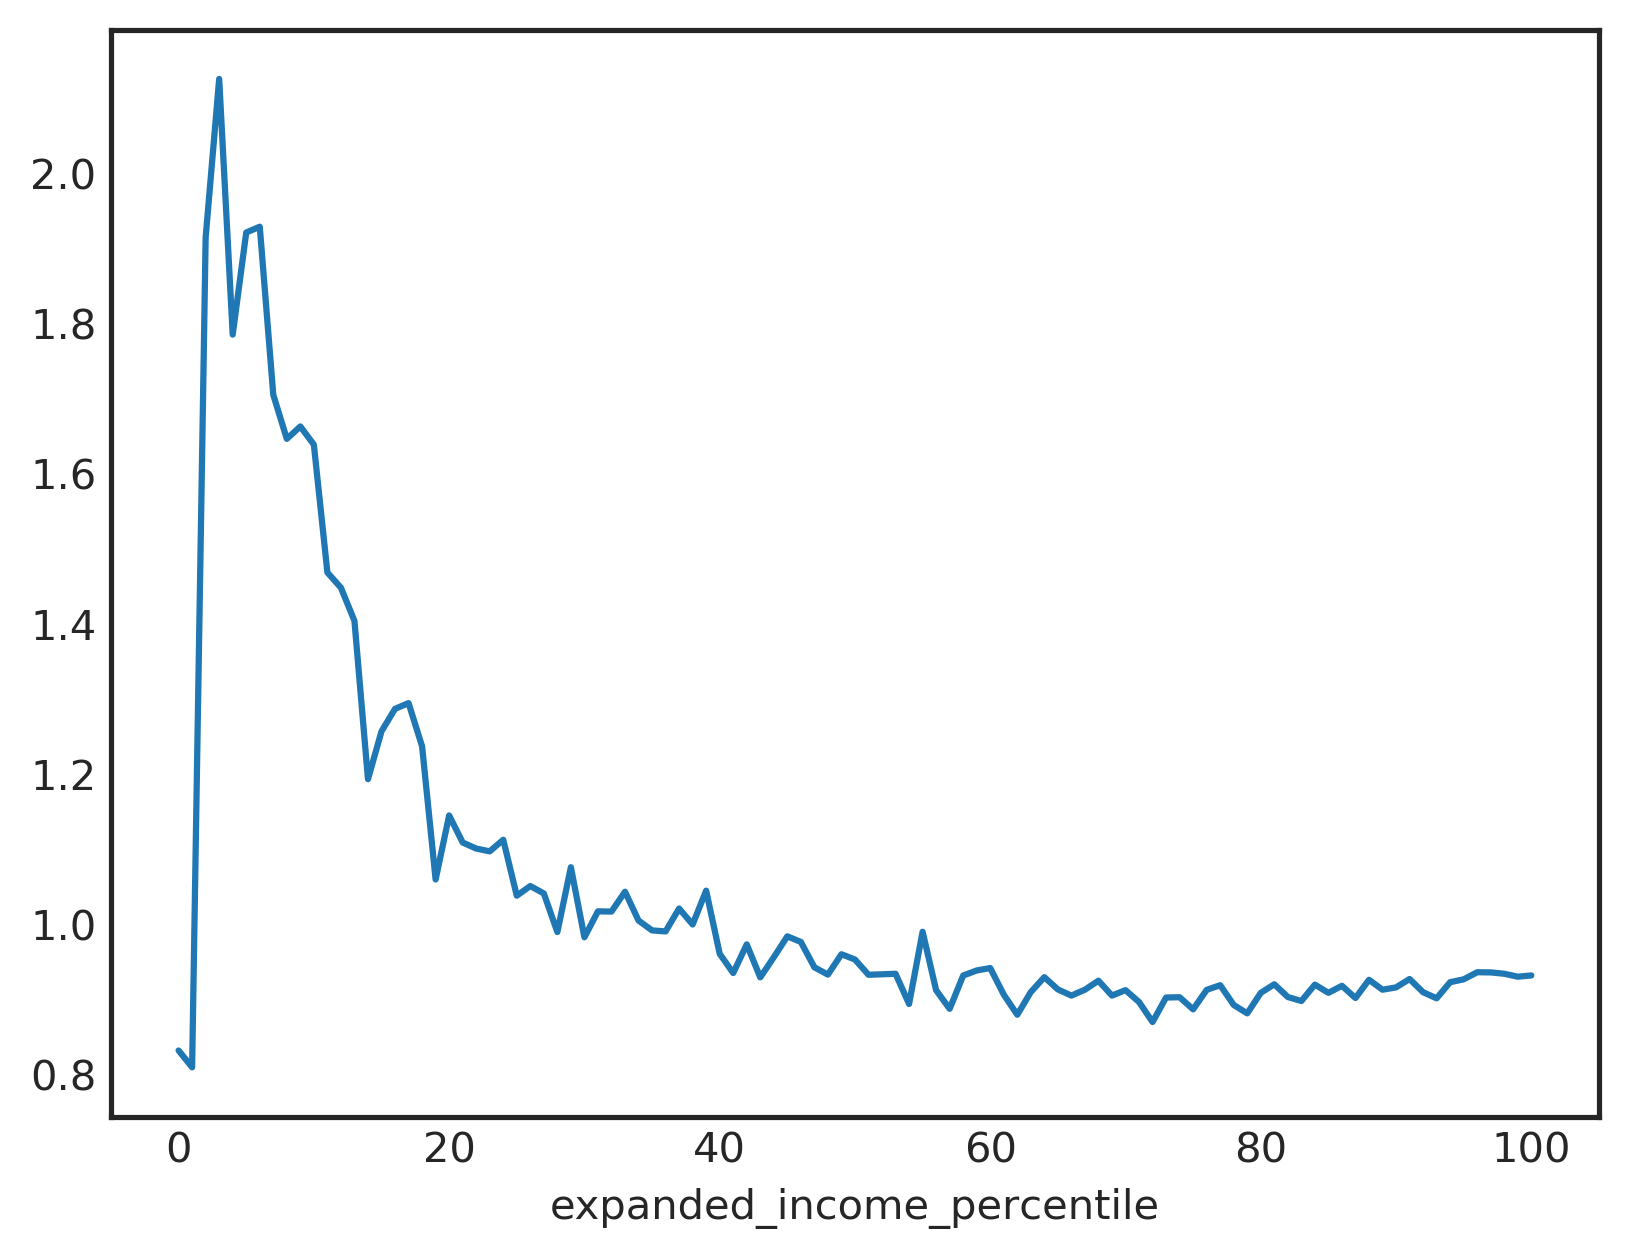

In [28]:
pct_e_cur['n24_per_nu18'].plot()
plt.show()

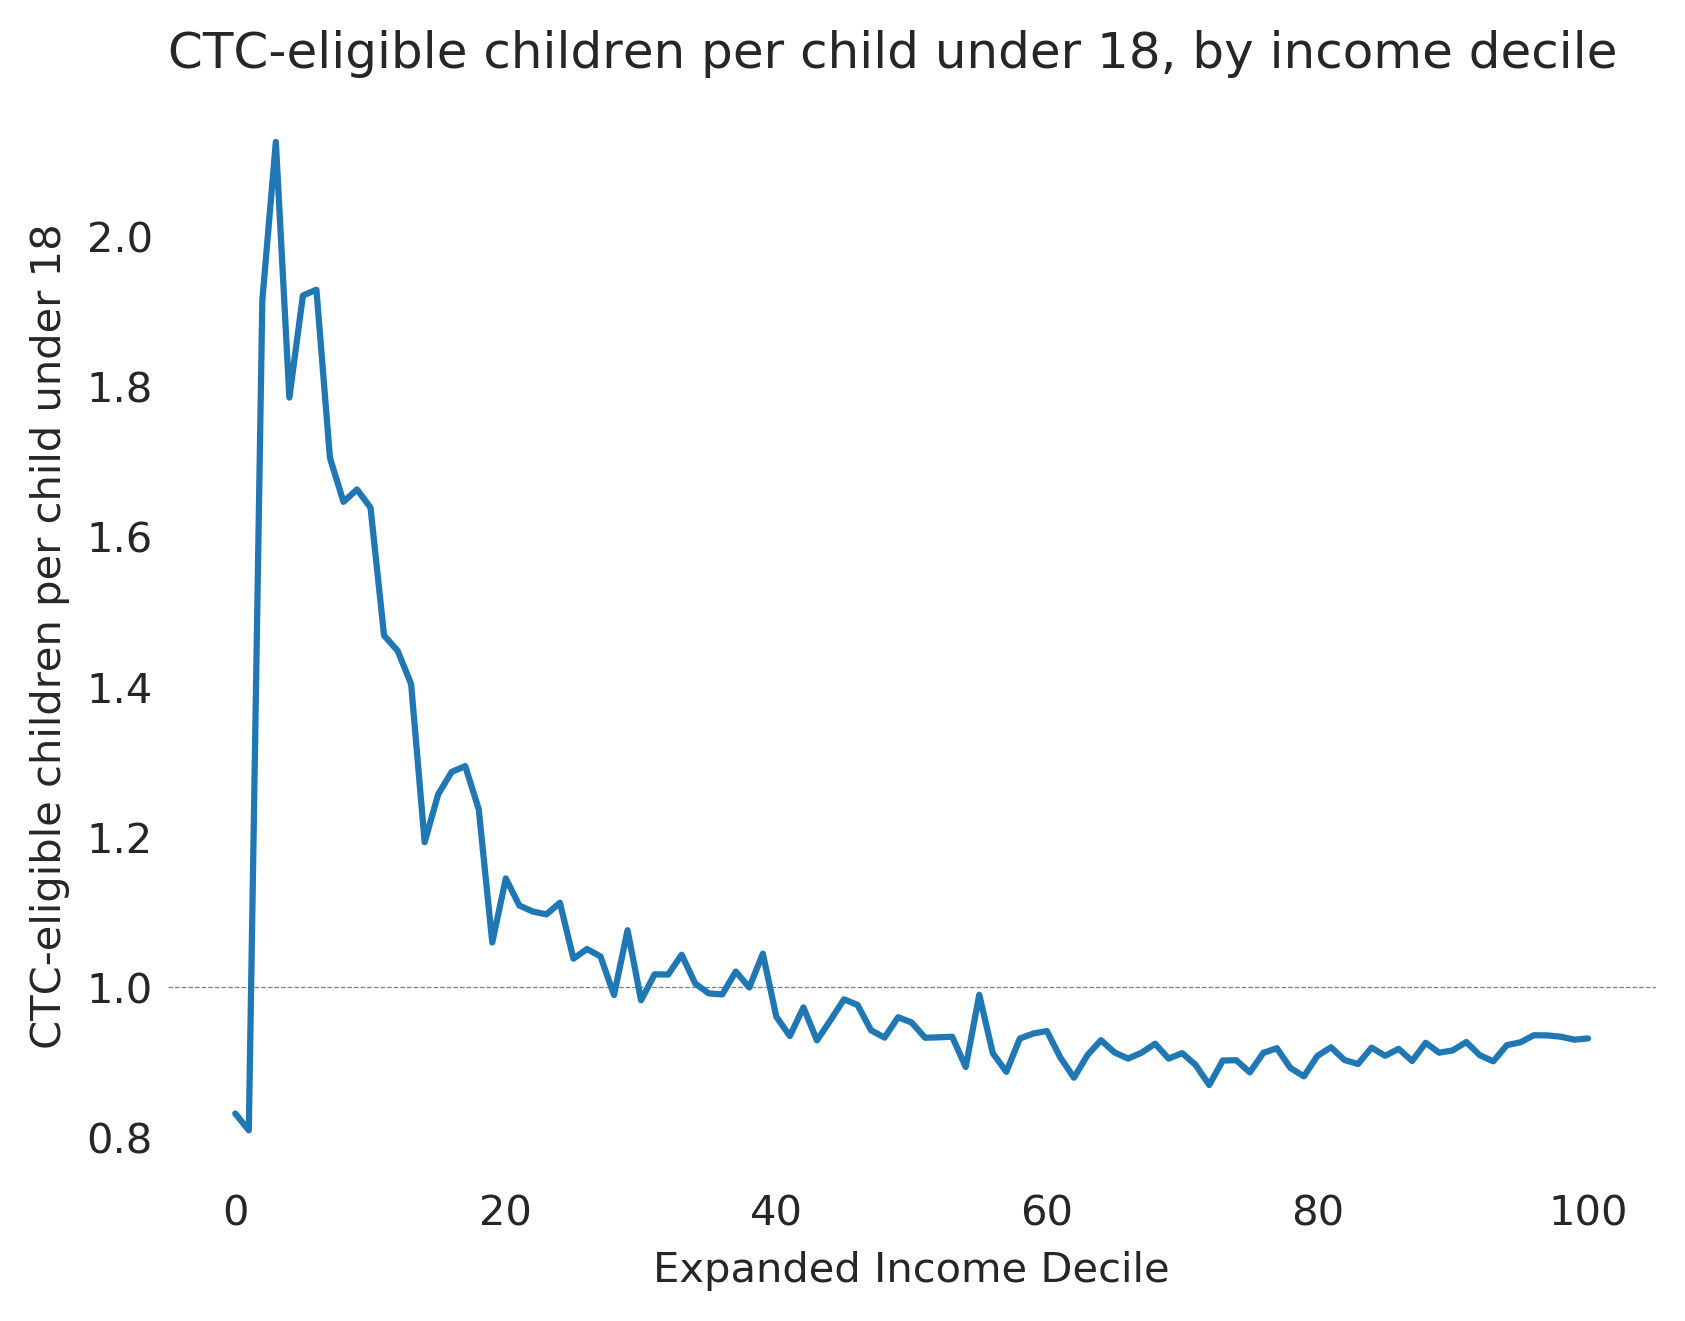

In [43]:
f, ax = plt.subplots() #figsize=(8, 8))

pct_e_cur['n24_per_nu18'].plot()

sns.despine(left=True, bottom=True)

ax.set(xlabel='Expanded Income Decile',
       ylabel='CTC-eligible children per child under 18')

plt.title('CTC-eligible children per child under 18, by income decile', loc='left') #, **roboto)
# TODO: Use `suptitle` for title and `title` for the subtitle, per https://stackoverflow.com/a/4490761/1840471.
# subtitle = ('Tax-Calculator 0.16.1  |  CPS data  ' +
#             '|  Excludes tax units with negative expanded income  |  2018 tax year  ' +
#             '|  Max Ghenis')
# plt.figtext(.5, .86, subtitle,
#             fontsize=4.5, ha='center')

plt.axhline(y=1, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)

plt.show()

### Distributional impact

In [220]:
scenario_pivot.columns

Index([u'id', u'use_2017_law', u'keep_aftertax_income_b',
       u'repeal_aftertax_income_b', u'rev_neutral_ubi_aftertax_income_b',
       u'top_ubi_aftertax_income_b', u'nu18', u'n24', u's006', u'nu18_m',
       u'n24_m', u'aftertax_income_percentile', u'aftertax_income_decile',
       u'aftertax_income_quintile', u'expanded_income_percentile',
       u'expanded_income_decile', u'expanded_income_quintile'],
      dtype='object')

In [227]:
scenario_pivot = scenarios.pivot_table(values=['aftertax_income_b'],
                                       index=['id', 'use_2017_law'],
                                       columns='ctc_treatment').reset_index()
# Adapted from https://stackoverflow.com/q/42099024/1840471.
scenario_pivot.columns = ["_".join((j, i)) for i, j in scenario_pivot.columns]
scenario_pivot.columns = scenario_pivot.columns.str.lstrip('_')

In [228]:
base_aftiq = scenarios.loc[scenarios['ctc_treatment'] == 'keep',
                             ['id', 'use_2017_law', 'nu18', 'n24', 's006', 'nu18_m', 'n24_m',
                              'aftertax_income_percentile', 'aftertax_income_decile',
                              'aftertax_income_quintile',
                              'expanded_income_percentile', 'expanded_income_decile',
                              'expanded_income_quintile']]

In [229]:
scenario_pivot = pd.merge(scenario_pivot, base_aftiq, on=['id', 'use_2017_law'])

In [239]:
def add_ratios(df):
    df['repeal_afti_chg'] = df['repeal_aftertax_income_b'] - df['keep_aftertax_income_b']
    df['repeal_afti_pctchg'] = df['repeal_afti_chg'] / df['keep_aftertax_income_b']
    df['ubi_afti_chg'] = df['rev_neutral_ubi_aftertax_income_b'] - df['keep_aftertax_income_b']
    df['ubi_afti_pctchg'] = df['ubi_afti_chg'] / df['rev_neutral_ubi_aftertax_income_b']
    #df['ubi_afti_chg_per_nu18'] = df['ubi_afti_chg'] / (df['nu18_m'] * 1000)
    df['ctc_per_n24'] = (
        (df['keep_aftertax_income_b'] - df['repeal_aftertax_income_b']) /
        (df['n24_m'] / 1000)).round()
    df['ctc_per_nu18'] = (
        (df['keep_aftertax_income_b'] - df['repeal_aftertax_income_b']) /
        (df['nu18_m'] * 1000)).round()

In [240]:
add_ratios(scenario_pivot)
scenario18 = scenario_pivot[~scenario_pivot['use_2017_law']].drop(columns='use_2017_law')
scenario17 = scenario_pivot[scenario_pivot['use_2017_law']].drop(columns='use_2017_law')

Verify maximum CTC.

In [247]:
scenario_pivot.groupby('use_2017_law')['ctc_per_n24'].max()

use_2017_law
False    2000.0
True     1000.0
Name: ctc_per_n24, dtype: float64

Merge to baseline after-tax income quantiles.

In [244]:
def quantile_summary(df, groupby):
    qs = df.groupby(groupby).sum()
    add_ratios(qs)
    # Exclude 0, the negative group.
    return qs.loc[1:]

In [245]:
quint = quantile_summary(scenario18, 'aftertax_income_quintile')
dec = quantile_summary(scenario18, 'aftertax_income_decile')
pct = quantile_summary(scenario18, 'aftertax_income_percentile')
quint_e = quantile_summary(scenario18, 'expanded_income_quintile')
dec_e = quantile_summary(scenario18, 'expanded_income_decile')
pct_e = quantile_summary(scenario18, 'expanded_income_percentile')

In [138]:
pct_e['nu18']

expanded_income_percentile
1       1202.0
2       1481.0
3       1181.0
4        802.0
5        850.0
6        882.0
7        876.0
8        916.0
9        845.0
10       857.0
11       944.0
12      1000.0
13      1090.0
14      1014.0
15      1192.0
16      1048.0
17       979.0
18      1101.0
19      1187.0
20      1285.0
21      1161.0
22      1165.0
23      1611.0
24      1510.0
25      1577.0
26      1466.0
27      1513.0
28      1617.0
29      1441.0
30      1442.0
        ...   
71      2580.0
72      2613.0
73      2709.0
74      2524.0
75      2636.0
76      2561.0
77      2706.0
78      2904.0
79      2929.0
80      2818.0
81      2996.0
82      3042.0
83      3467.0
84      3349.0
85      3307.0
86      3846.0
87      3806.0
88      4049.0
89      4220.0
90      4117.0
91      4135.0
92      4260.0
93      4261.0
94      4488.0
95      5334.0
96      9178.0
97     13697.0
98     13975.0
99     18485.0
100    27863.0
Name: nu18, Length: 100, dtype: float64

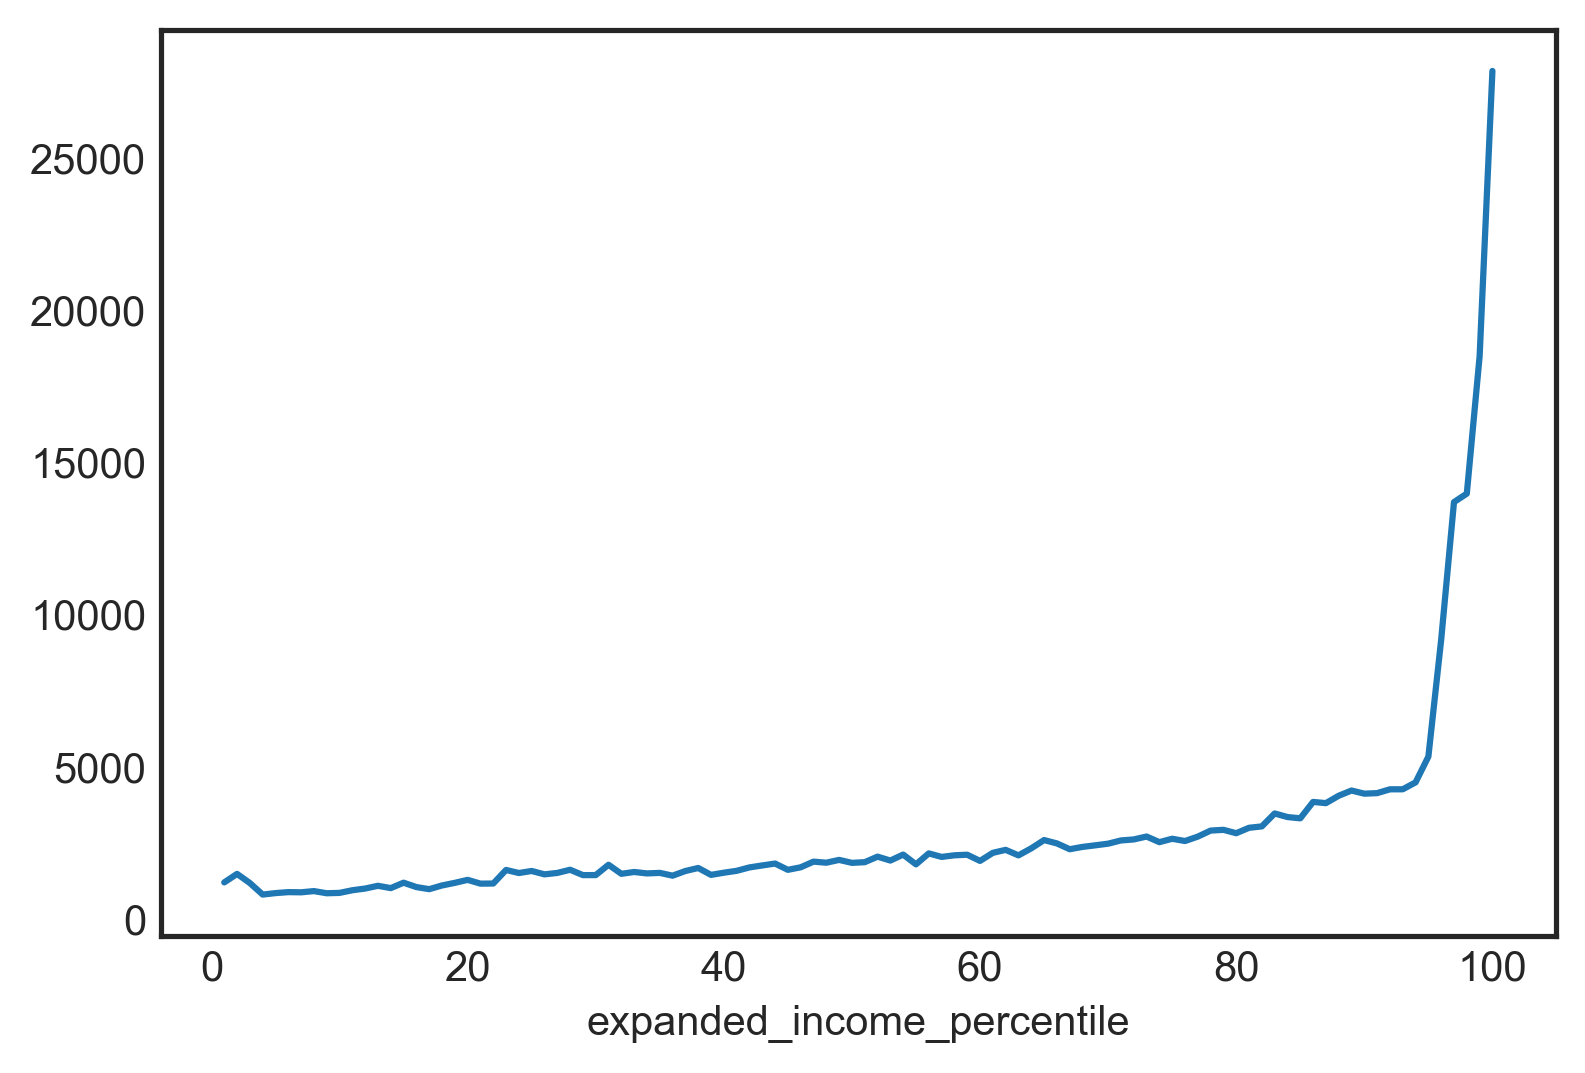

In [137]:
pct_e['nu18'].plot()
plt.show()

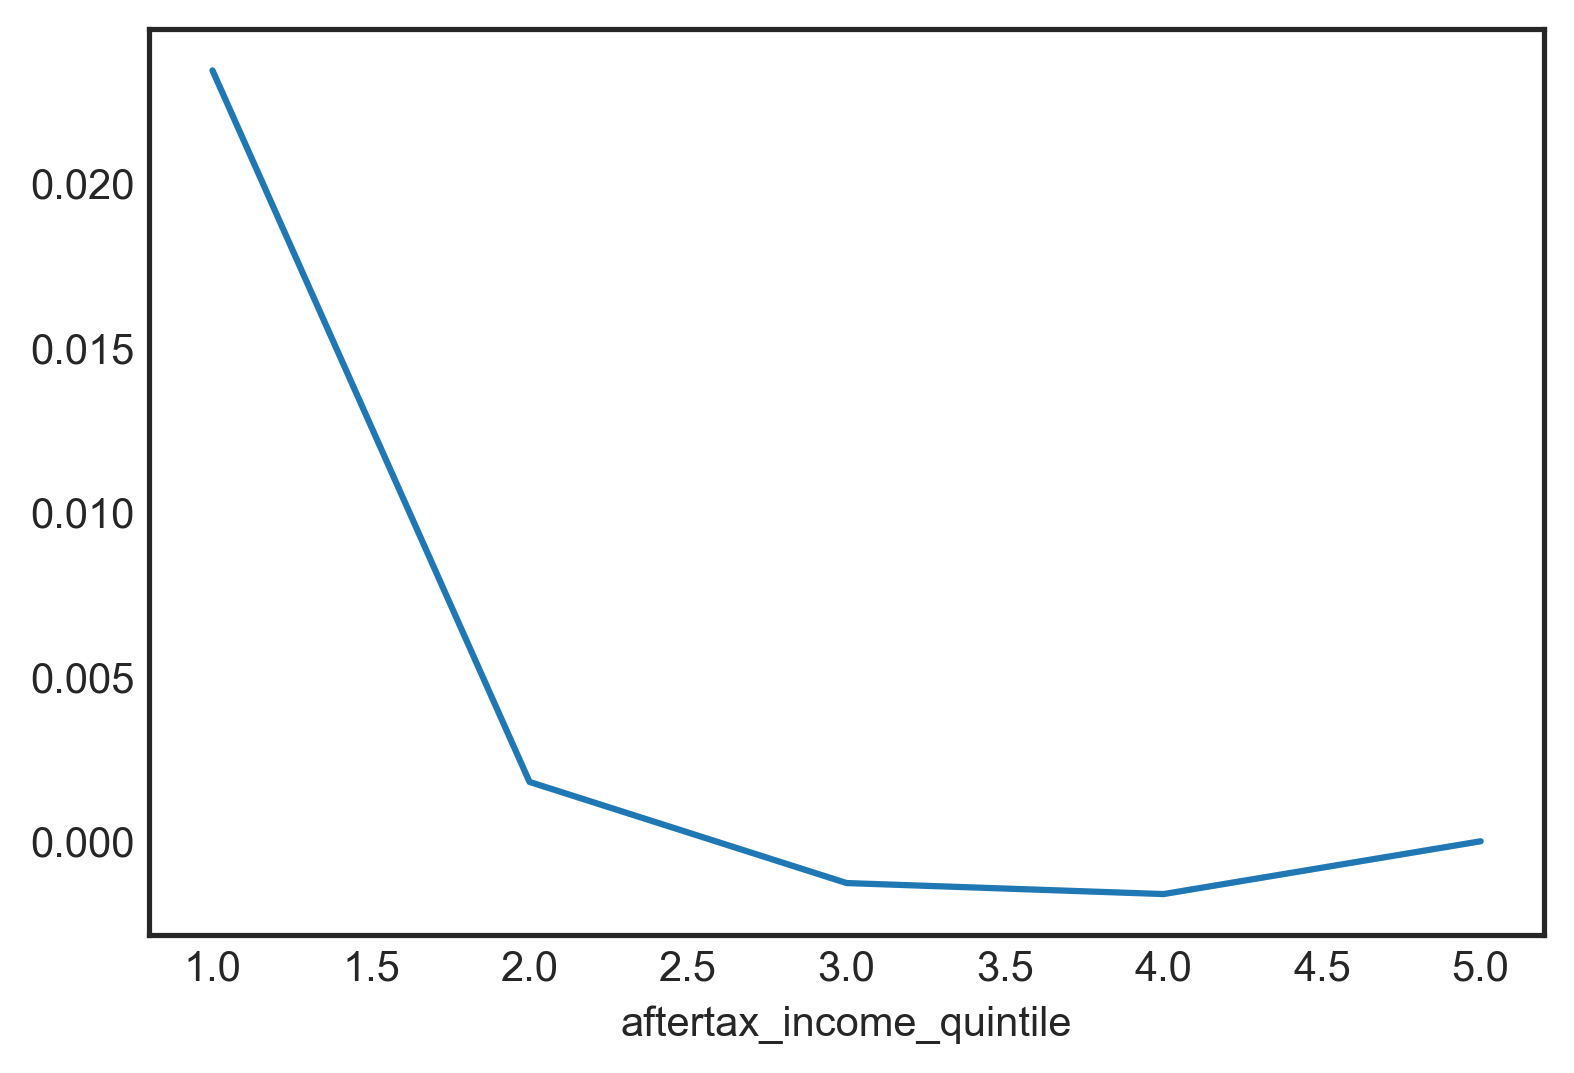

In [87]:
quint['ubi_afti_pctchg'].plot()
plt.show()

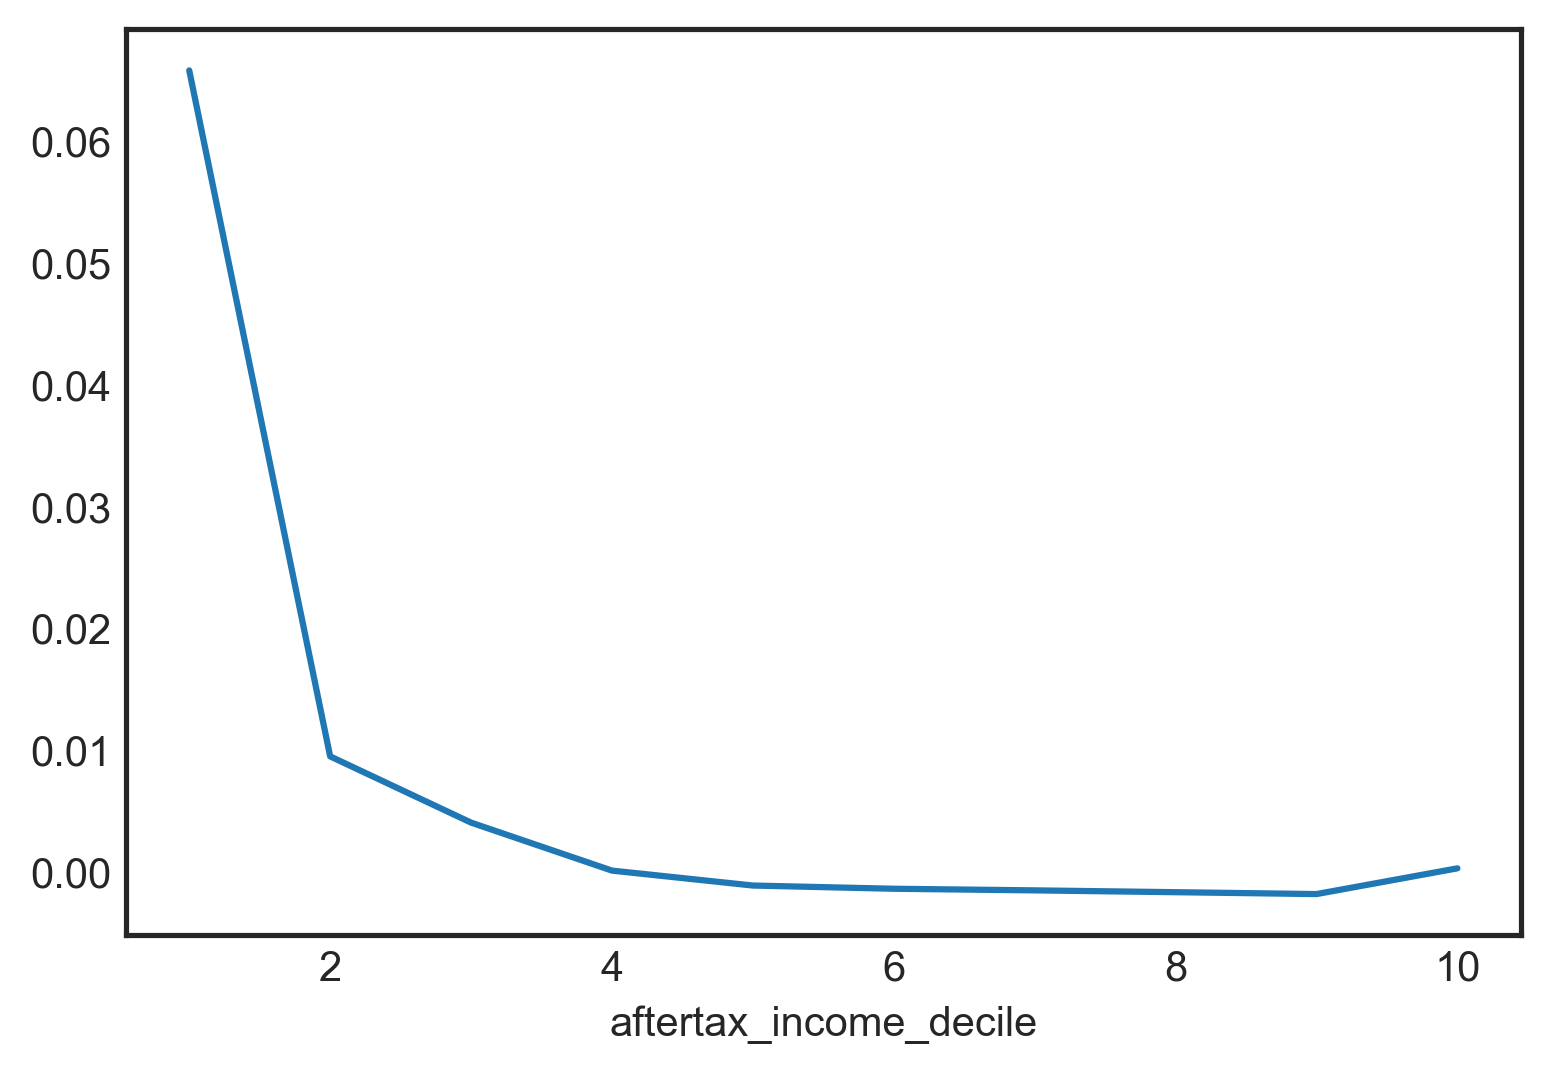

In [88]:
dec['ubi_afti_pctchg'].plot()
plt.show()

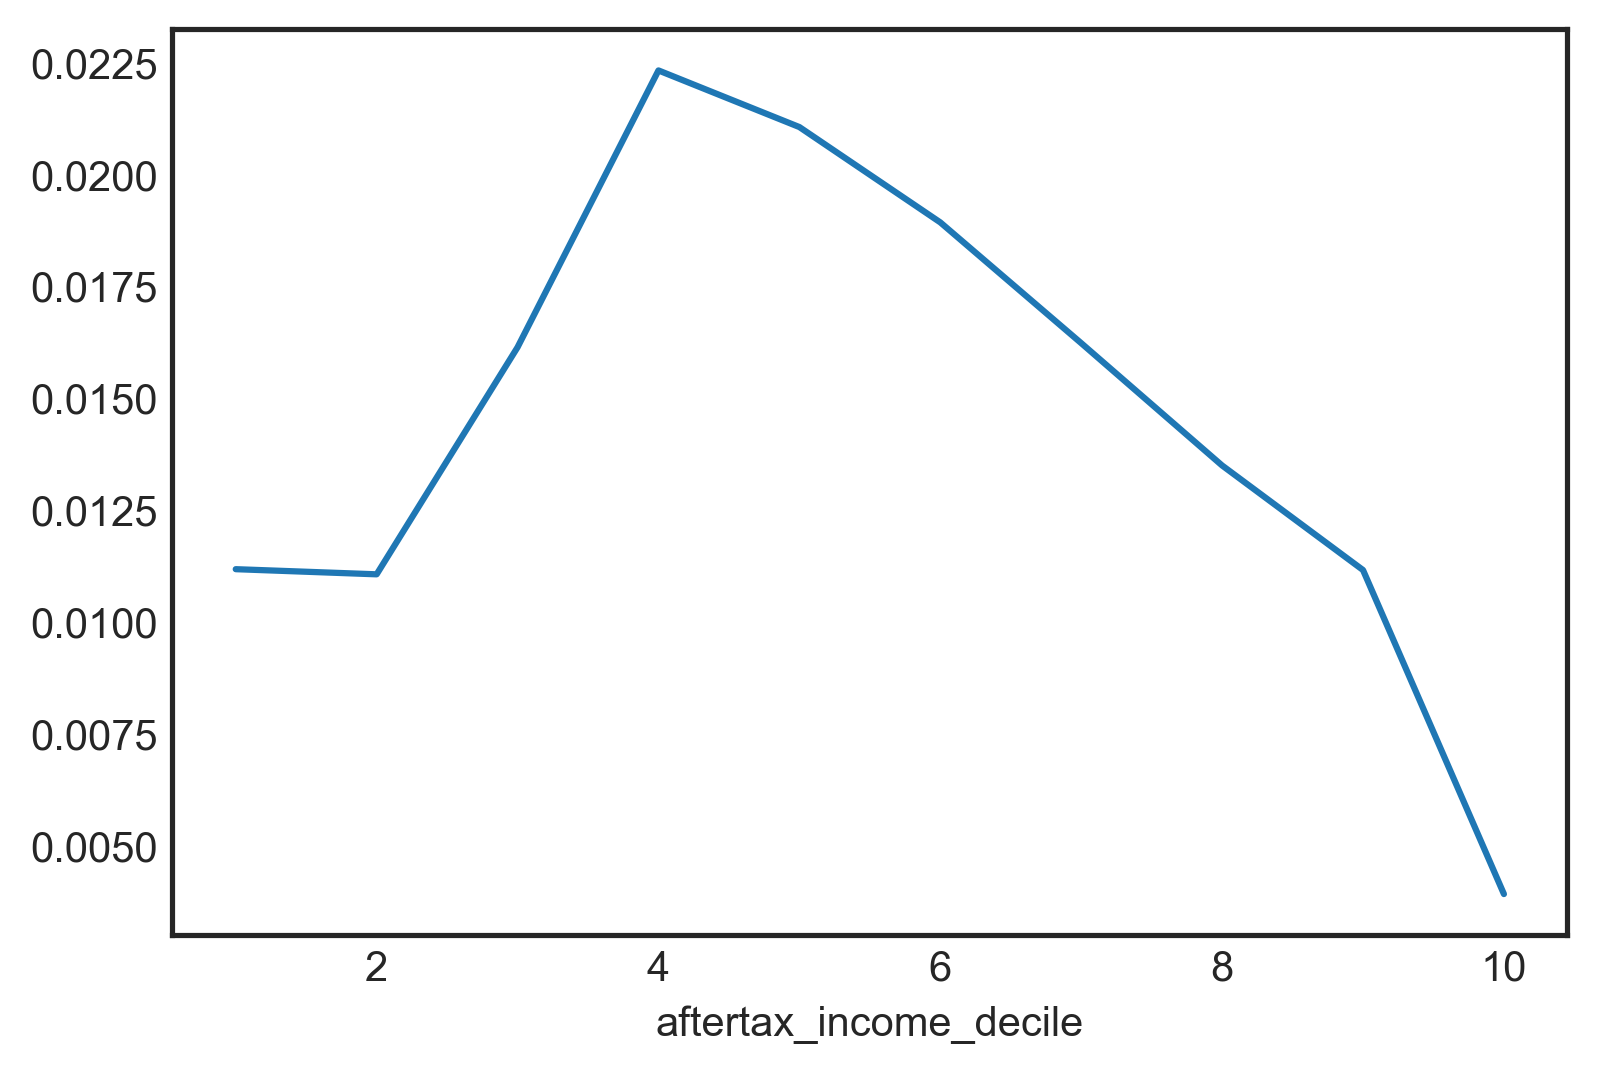

In [121]:
(-dec['repeal_afti_pctchg']).plot()
plt.show()

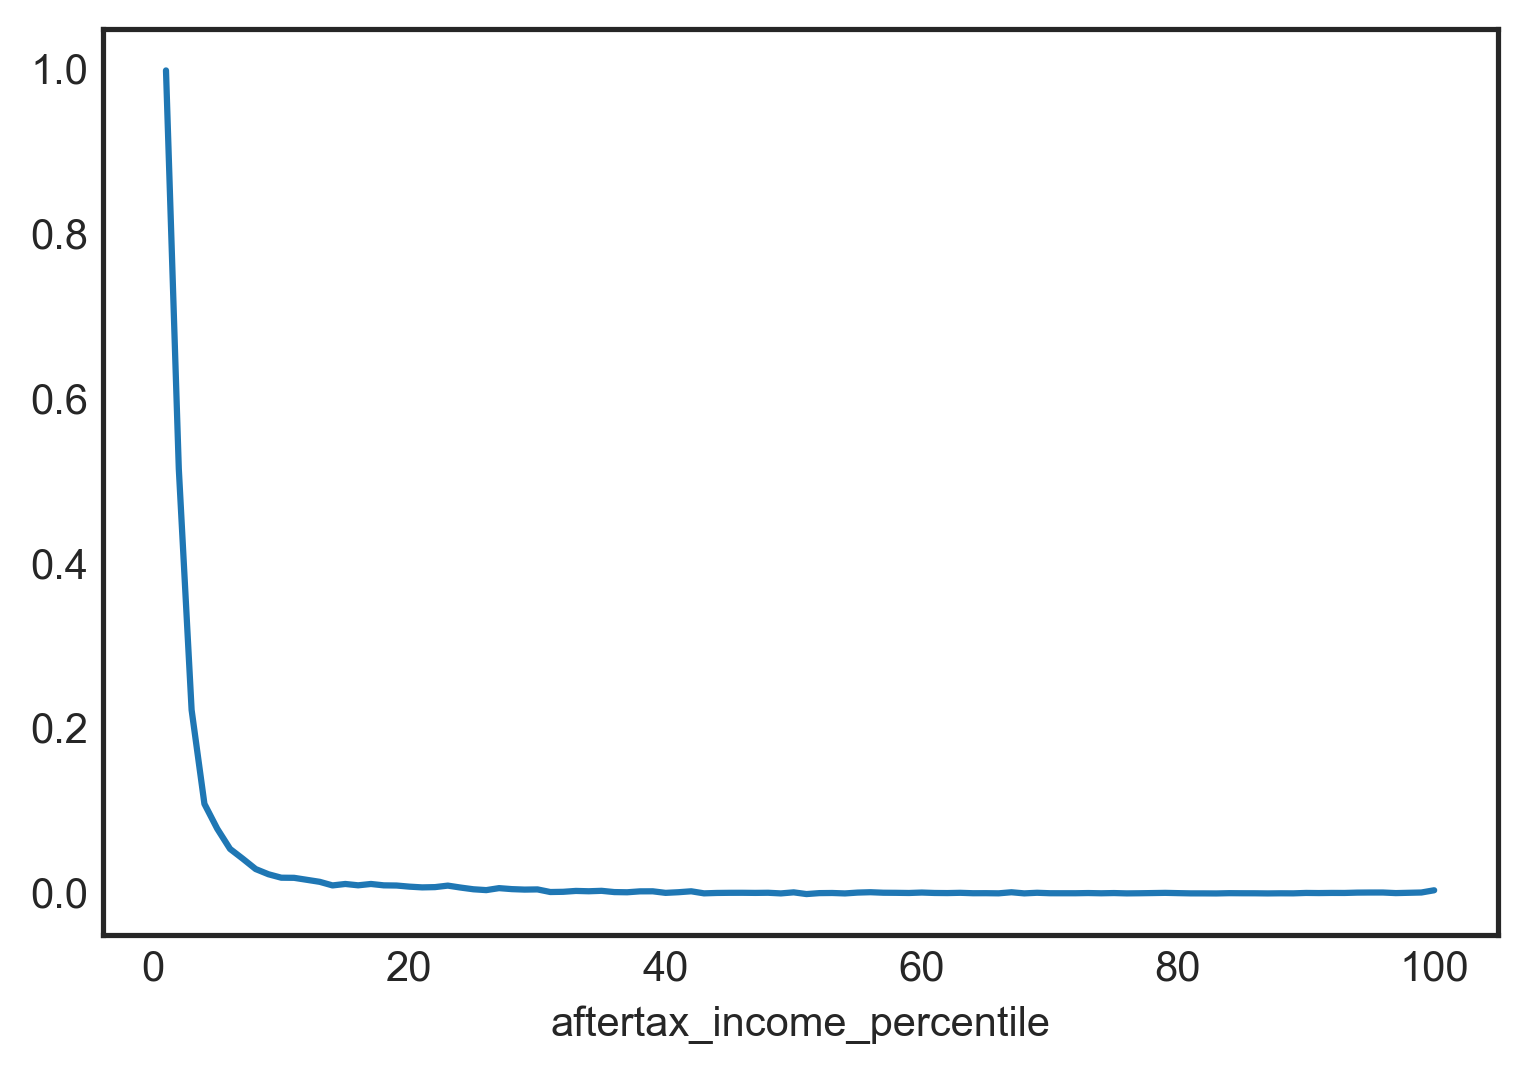

In [89]:
pct['ubi_afti_pctchg'].plot()
plt.show()

In [90]:
pct['ubi_afti_pctchg']

aftertax_income_percentile
1      0.997135
2      0.513500
3      0.220740
4      0.106696
5      0.076551
6      0.052030
7      0.040044
8      0.027583
9      0.021248
10     0.017078
11     0.016923
12     0.014500
13     0.012069
14     0.007707
15     0.009464
16     0.007828
17     0.009463
18     0.007793
19     0.007583
20     0.006218
21     0.005318
22     0.005642
23     0.007474
24     0.005099
25     0.003017
26     0.002001
27     0.004411
28     0.003208
29     0.002630
30     0.002863
         ...   
71    -0.001805
72    -0.001798
73    -0.001549
74    -0.001841
75    -0.001570
76    -0.001960
77    -0.001807
78    -0.001577
79    -0.001322
80    -0.001658
81    -0.001947
82    -0.001964
83    -0.002039
84    -0.001712
85    -0.001807
86    -0.001844
87    -0.002003
88    -0.001850
89    -0.001925
90    -0.001416
91    -0.001576
92    -0.001403
93    -0.001445
94    -0.001031
95    -0.000925
96    -0.000909
97    -0.001614
98    -0.001244
99    -0.000890
100    0.0018

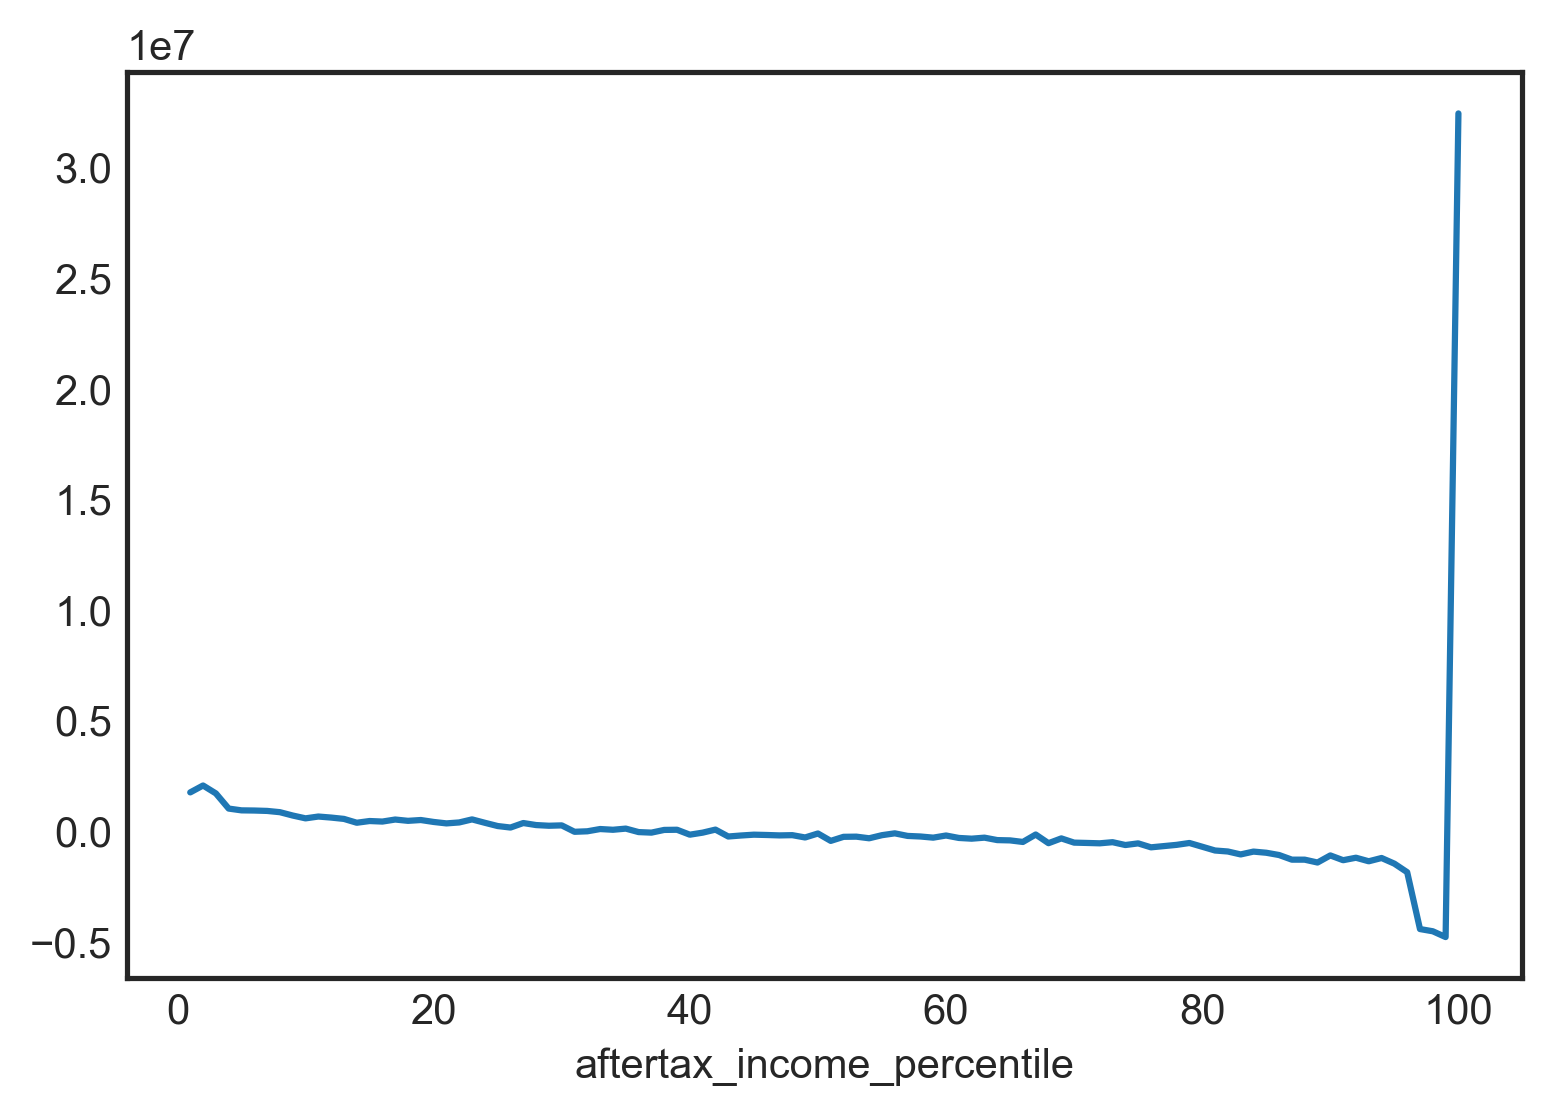

In [91]:
pct['ubi_afti_chg'].plot()
plt.show()

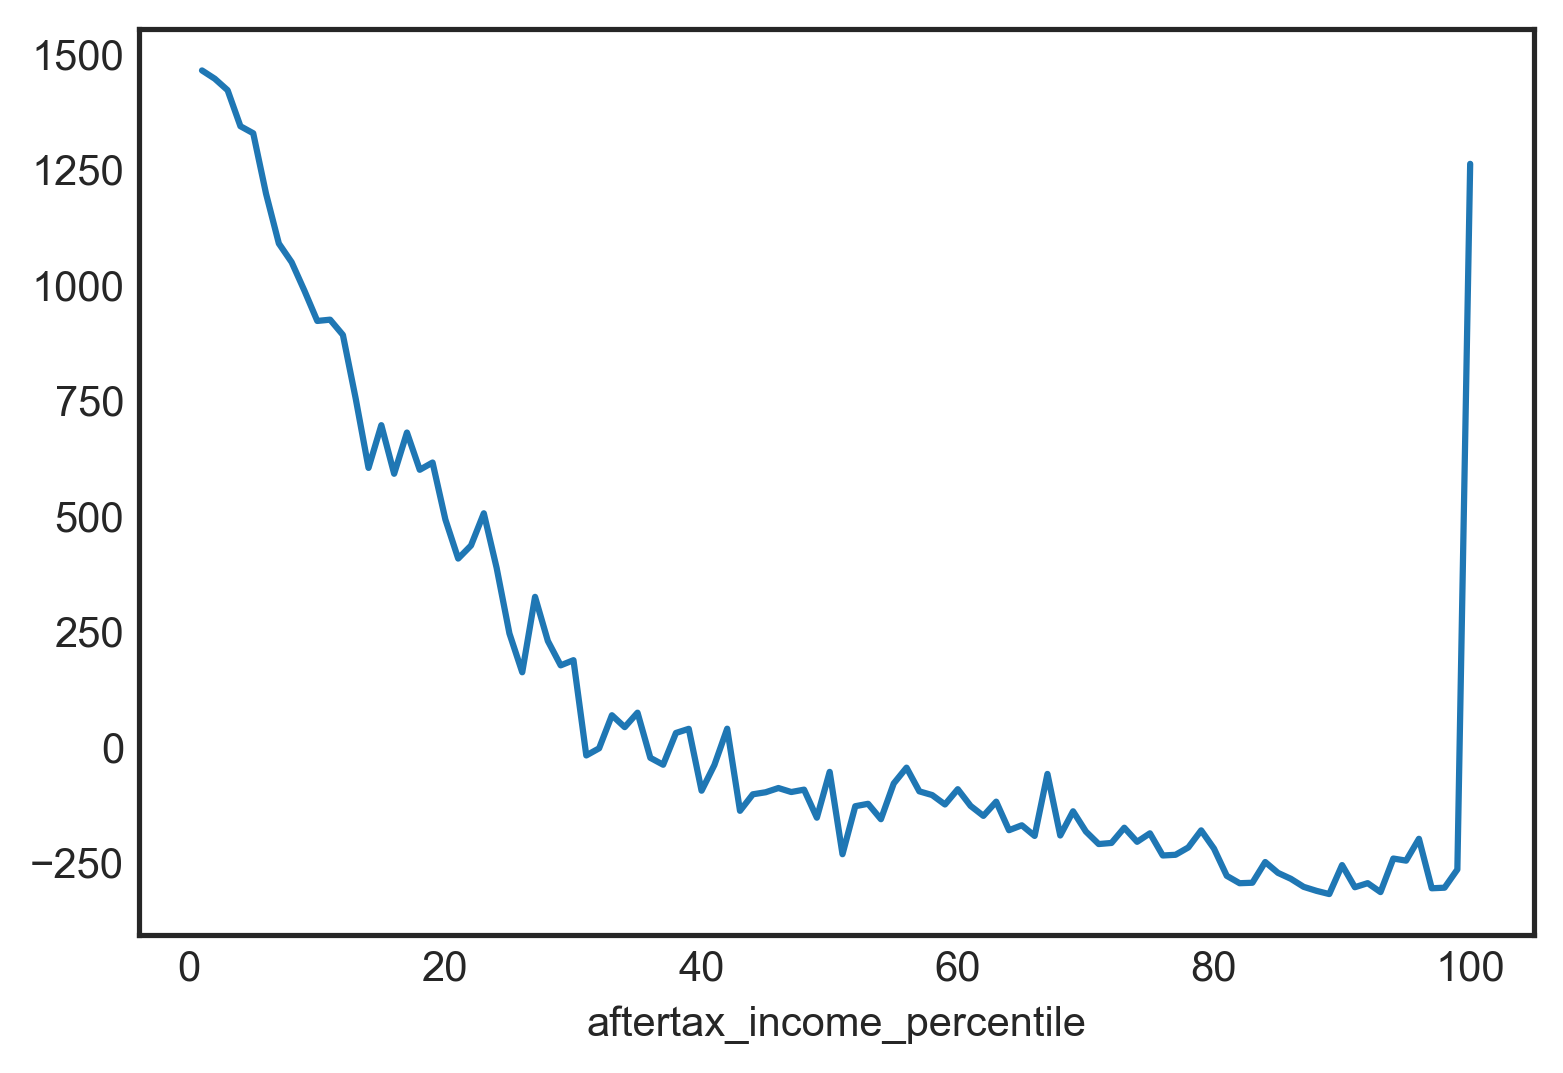

In [94]:
pct['ubi_afti_chg_per_nu18'].plot()
plt.show()

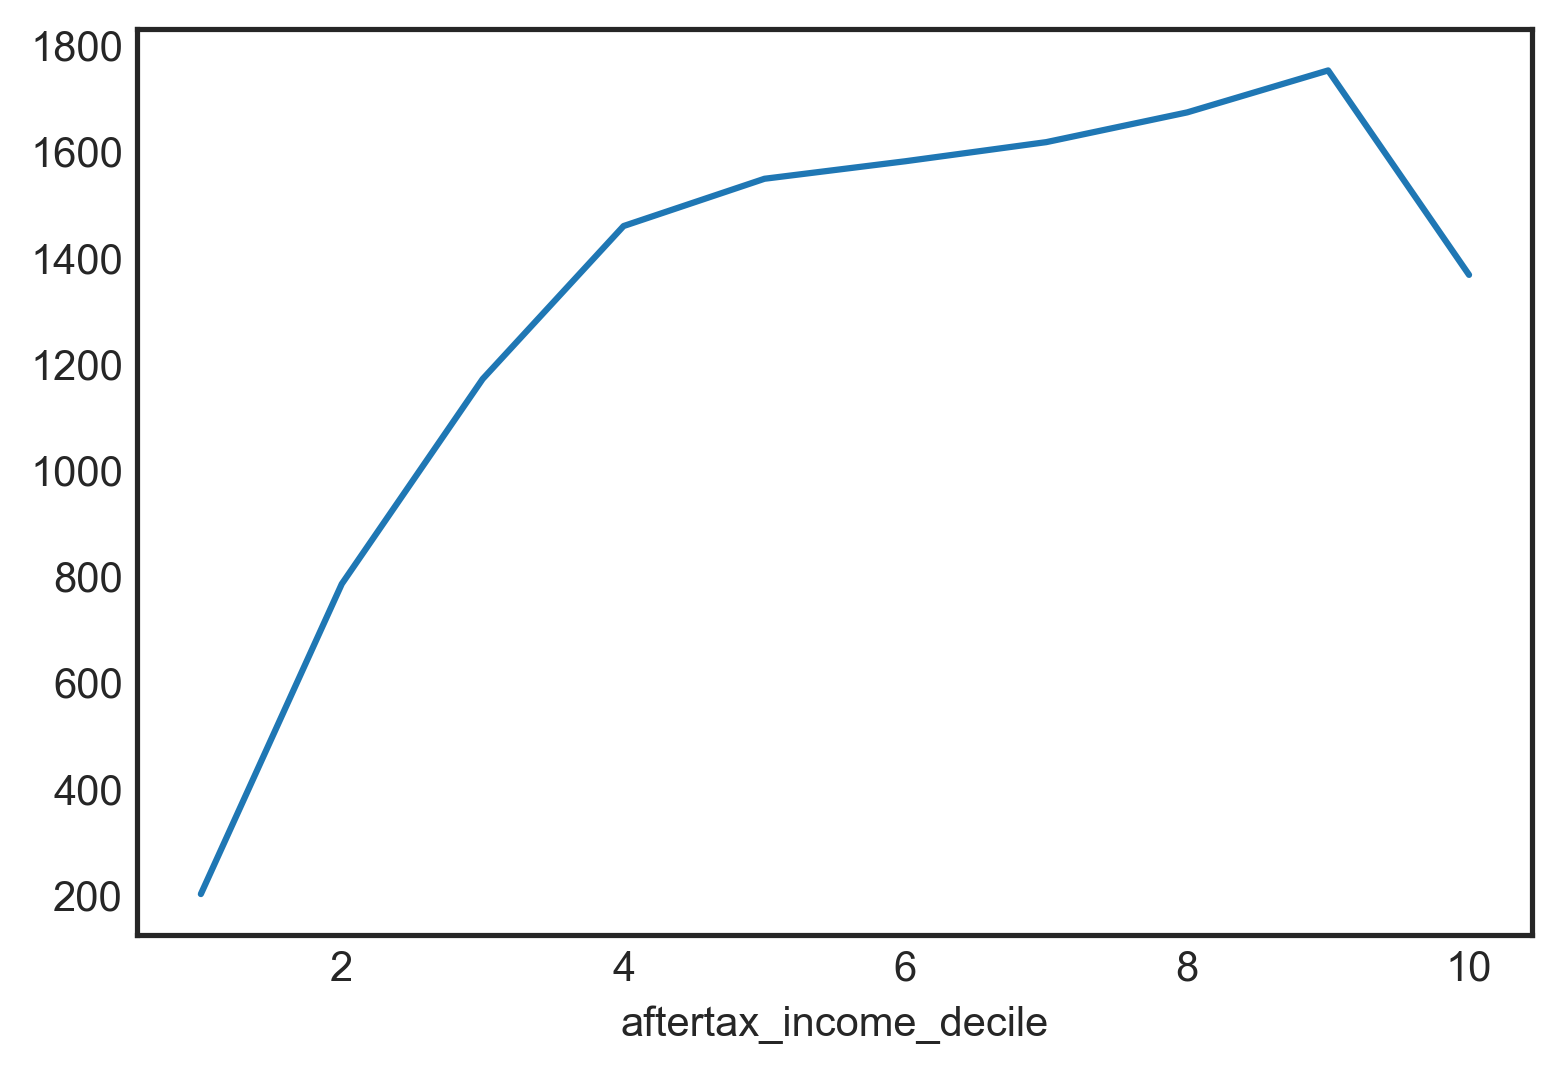

In [78]:
dec['ctc_per_nu18'].plot()
plt.show()

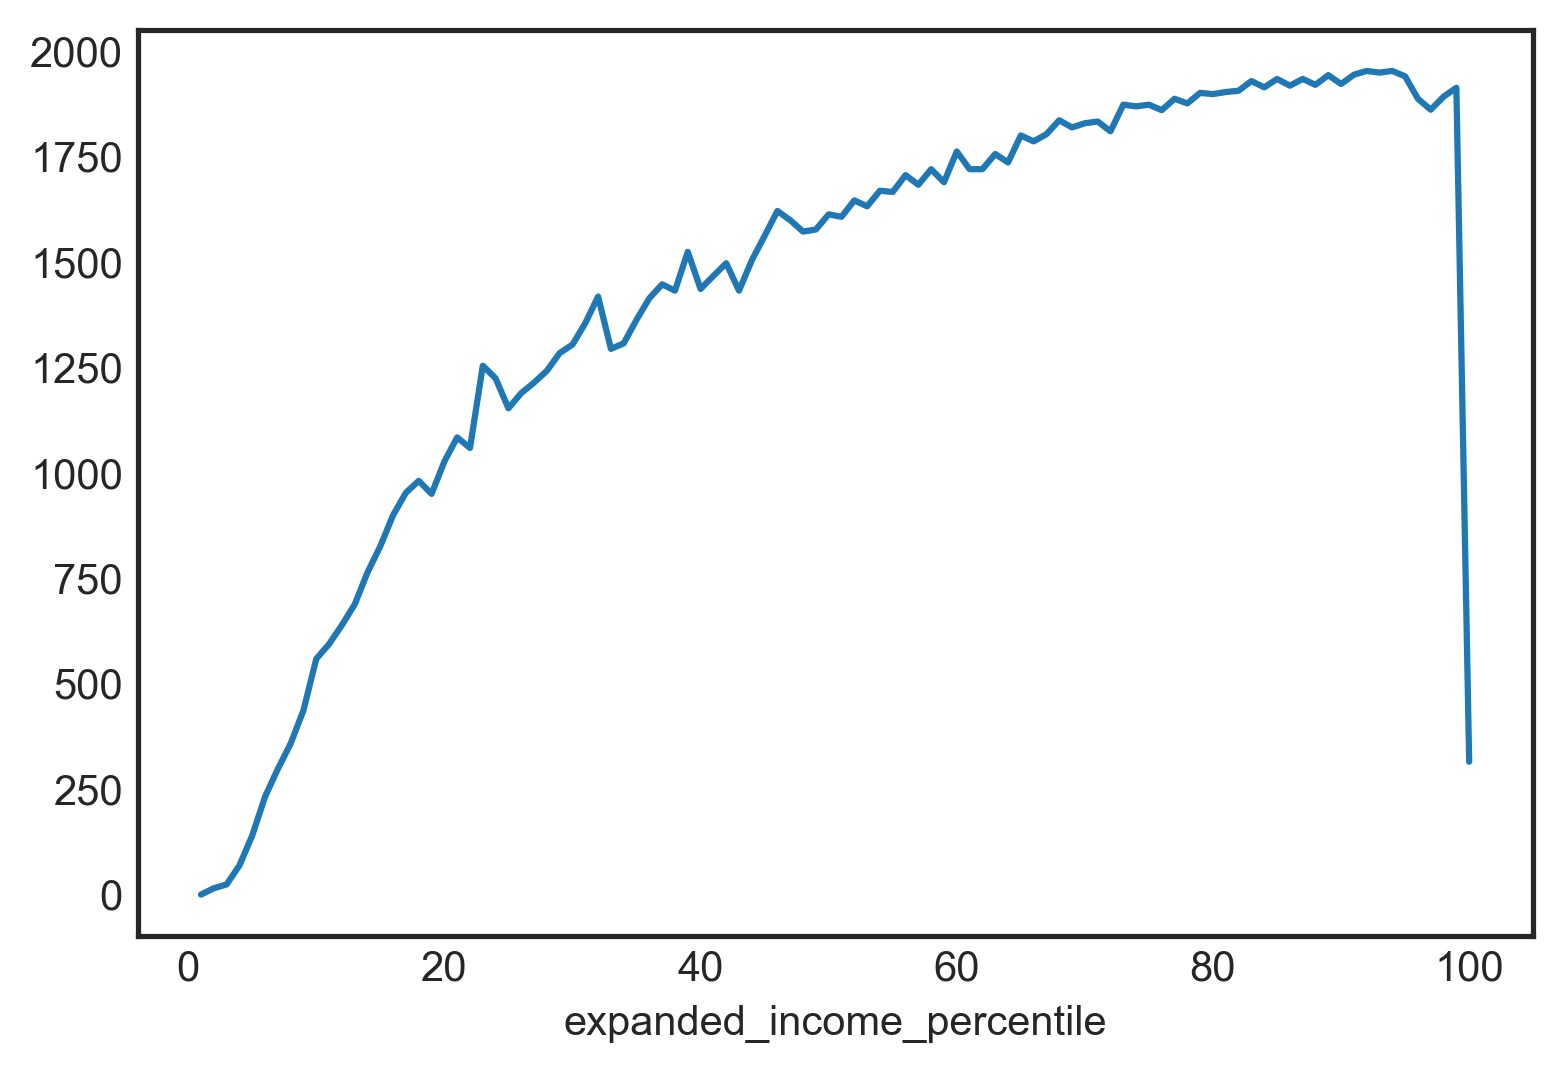

In [133]:
pct_e['ctc_per_n24'].plot()
plt.show()

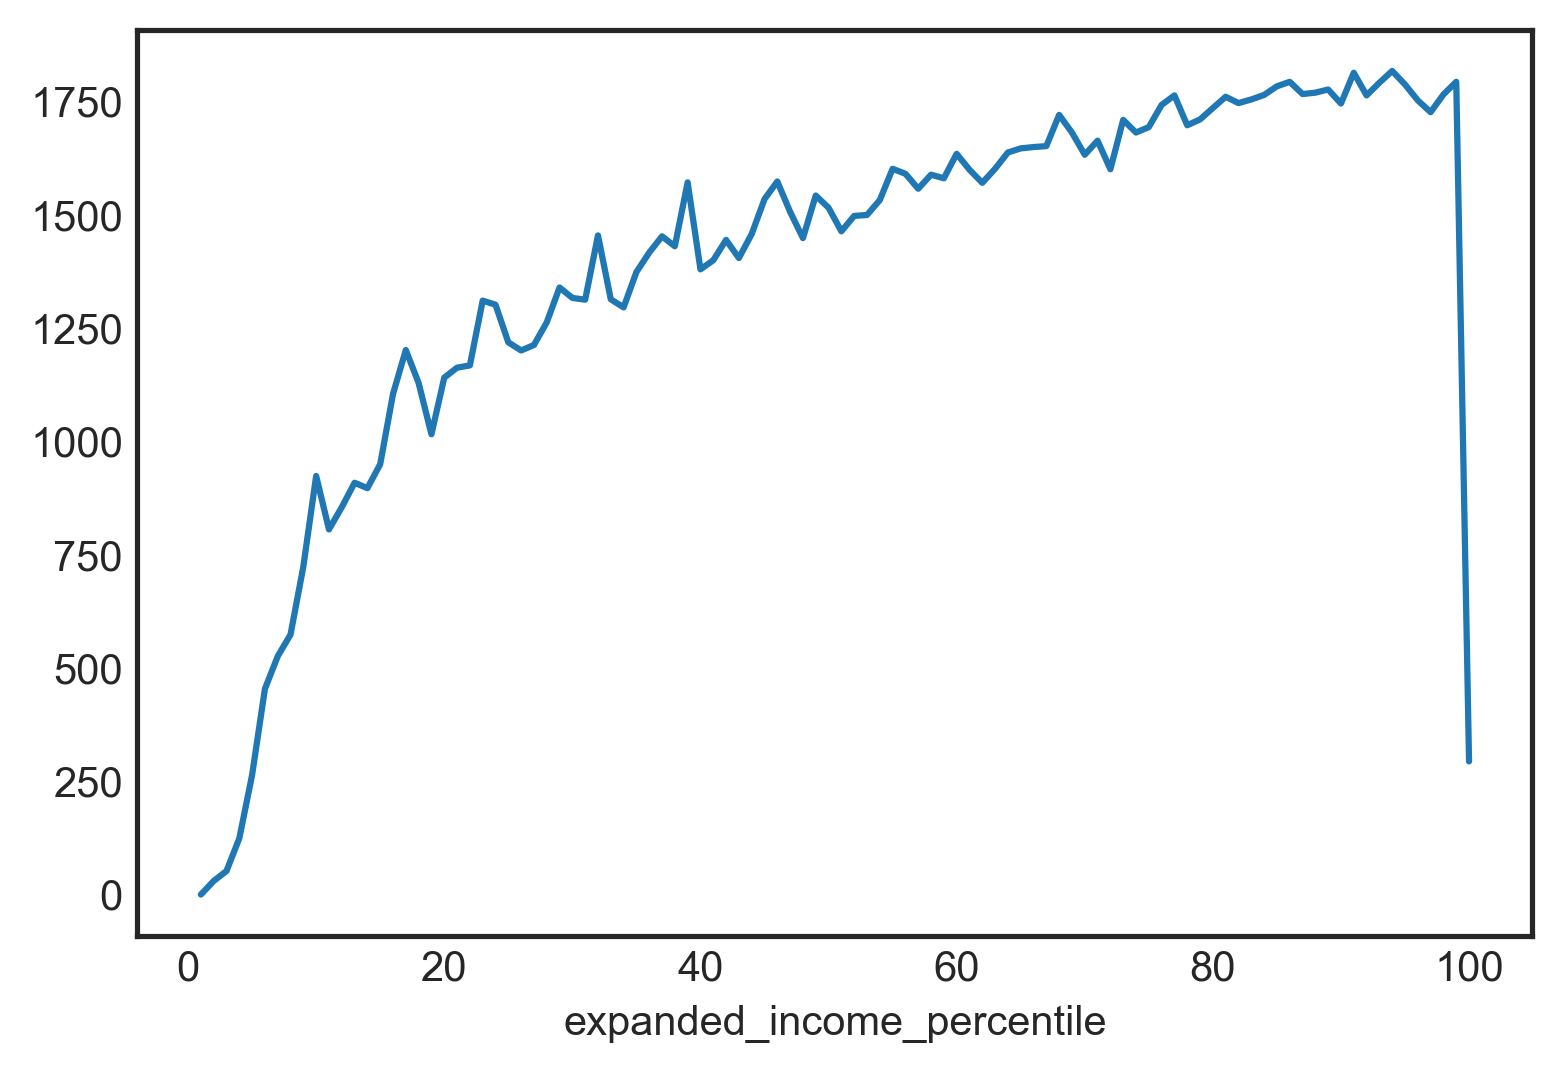

In [134]:
pct_e['ctc_per_nu18'].plot()
plt.show()

In [80]:
pct['ctc_per_nu18']

aftertax_income_percentile
1         1.0
2        19.0
3        44.0
4       122.0
5       137.0
6       268.0
7       376.0
8       416.0
9       478.0
10      543.0
11      541.0
12      574.0
13      711.0
14      861.0
15      769.0
16      874.0
17      785.0
18      865.0
19      850.0
20      973.0
21     1058.0
22     1029.0
23      960.0
24     1078.0
25     1220.0
26     1304.0
27     1140.0
28     1236.0
29     1289.0
30     1277.0
        ...  
71     1675.0
72     1673.0
73     1640.0
74     1671.0
75     1652.0
76     1700.0
77     1699.0
78     1683.0
79     1646.0
80     1685.0
81     1744.0
82     1760.0
83     1759.0
84     1714.0
85     1738.0
86     1751.0
87     1768.0
88     1777.0
89     1784.0
90     1721.0
91     1769.0
92     1760.0
93     1779.0
94     1707.0
95     1711.0
96     1664.0
97     1771.0
98     1770.0
99     1730.0
100     203.0
Name: ctc_per_nu18, Length: 100, dtype: float64

## Appendix

Tax units with greatest change to after-tax income from the UBI model.

In [249]:
scenario18[(scenario18['rev_neutral_ubi_aftertax_income_b'] >= 0) &
           (scenario18['keep_aftertax_income_b'] >= 0) &
           (scenario18['ubi_afti_chg'] < np.inf)].sort_values('ubi_afti_chg').tail()

,id,keep_aftertax_income_b,repeal_aftertax_income_b,rev_neutral_ubi_aftertax_income_b,top_ubi_aftertax_income_b,nu18,n24,s006,nu18_m,n24_m,...,aftertax_income_quintile,expanded_income_percentile,expanded_income_decile,expanded_income_quintile,repeal_afti_chg,repeal_afti_pctchg,ubi_afti_chg,ubi_afti_pctchg,ctc_per_n24,ctc_per_nu18
416420,208210,9.5e-02,9.5e-02,1.1e-01,1.1e-01,5.0,3.0,1960.3,9.8e-03,5.9e-03,...,3,49,5,3,0.0e+00,0.0e+00,1.4e-02,0.1,0.0,0.0
474510,237255,4.6e-02,4.6e-02,6.0e-02,6.5e-02,5.0,0.0,1964.3,9.8e-03,0.0e+00,...,2,25,3,2,0.0e+00,0.0e+00,1.4e-02,0.2,NaN,0.0
55834,27917,1.1e-01,1.1e-01,1.3e-01,1.3e-01,10.0,3.0,1195.8,1.2e-02,3.6e-03,...,4,72,8,4,-2.1e-03,-1.9e-02,1.5e-02,0.1,576.0,0.0
519080,259540,0.0e+00,0.0e+00,1.7e-02,2.3e-02,4.0,3.0,2833.1,1.1e-02,8.5e-03,...,1,1,1,1,0.0e+00,NaN,1.7e-02,1.0,0.0,0.0
646484,323242,9.8e-02,9.8e-02,1.2e-01,1.3e-01,9.0,0.0,1651.6,1.5e-02,0.0e+00,...,4,57,6,3,0.0e+00,0.0e+00,2.2e-02,0.2,NaN,0.0


## Utility functions

In [257]:
# Function that takes a set of dimensions and metrics, and 
# creates a summary table where metrics are properly weighted.